In [ ]:
# Import python packages
import numpy as np
import pandas as pd
import scipy as sp
import sklearn as sk
import seaborn as sns
import matplotlib.pyplot as plt


# Load imputed Houston data
df_houston = pd.read_pickle("houston_df.pkl")

from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np


from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform, randint


In [75]:
print(df_houston)

                  cuisine product_type     revenue        cost    cases  \
0                   Asian     Non Food    64848.40    40577.02   1700.0   
1                   Asian     Non Food    67882.92    45765.28   1706.0   
2                   Asian     Non Food    67106.98    46050.63   1707.0   
3                   Asian     Non Food    79953.54    46981.28   1830.0   
4                   Asian     Non Food    65375.47    42107.22   1841.0   
...                   ...          ...         ...         ...      ...   
1515  Mainstream American     Proteins  1239347.31  1108906.52  12105.0   
1516  Mainstream American     Proteins  1232865.06  1096102.99  11995.0   
1517  Mainstream American     Proteins  1410584.59  1255203.38  13602.0   
1518  Mainstream American     Proteins  1372757.72  1104560.71  12246.0   
1519  Mainstream American     Proteins  1263746.98  1017769.43  12580.0   

      customer_count     city       week  
0              135.0  HOUSTON 2020-06-29  
1            

Preprocessing for TimeSeries analysis

In [76]:

# Ensure chronological order and datetime format
df_houston = df_houston.sort_values('week').reset_index(drop=True)
df_houston['week'] = pd.to_datetime(df_houston['week'])

# Extract time features
df_houston['week_num'] = df_houston['week'].dt.isocalendar().week
df_houston['month'] = df_houston['week'].dt.month
df_houston['quarter'] = df_houston['week'].dt.quarter
df_houston['year'] = df_houston['week'].dt.year

# Add lag and rolling features
df_houston['revenue_lag1'] = df_houston.groupby(['cuisine', 'product_type'])['revenue'].shift(1)
df_houston['cost_lag1'] = df_houston.groupby(['cuisine', 'product_type'])['cost'].shift(1)
df_houston['revenue_roll3'] = df_houston.groupby(['cuisine', 'product_type'])['revenue'].shift(1).rolling(3).mean()
df_houston['cost_roll3'] = df_houston.groupby(['cuisine', 'product_type'])['cost'].shift(1).rolling(3).mean()

# Drop rows with NaNs created by lags
df_houston = df_houston.dropna().reset_index(drop=True)

# Store week values before encoding for later plotting
week_values = df_houston['week'].reset_index(drop=True)

# One-hot encode categorical variables
df_houston = pd.get_dummies(df_houston, columns=['cuisine', 'product_type'], drop_first=True)

# Prepare features and target
X = df_houston.drop(columns=['revenue', 'week', 'city'])
y = df_houston['revenue']

# Capture the weeks at the same moment you define X and y
weeks_for_plotting = df_houston['week'].reset_index(drop=True)




X_train, X_test = X[:-12], X[-12:]
y_train, y_test = y[:-12], y[-12:]
test_weeks = weeks_for_plotting[-12:].reset_index(drop=True)




In [77]:

# 1. Train/Test split (already done):
X_train, X_test = X[:-12], X[-12:]
y_train, y_test = y[:-12], y[-12:]

# 2. Train Random Forest
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# 3. Train XGBoost
xgb = XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
xgb.fit(X_train, y_train)

# 4. Predictions
rf_preds = rf.predict(X_test)
xgb_preds = xgb.predict(X_test)

# 5. Evaluation metrics
def evaluate_model(name, y_true, y_pred):
    print(f"{name} Performance:")
    print(f"  RMSE: {np.sqrt(mean_squared_error(y_true, y_pred)):.2f}")
    print(f"  MAE:  {mean_absolute_error(y_true, y_pred):.2f}")
    print(f"  R²:   {r2_score(y_true, y_pred):.3f}")
    print("")

evaluate_model("Random Forest", y_test, rf_preds)
evaluate_model("XGBoost", y_test, xgb_preds)

Random Forest Performance:
  RMSE: 17391.87
  MAE:  11614.13
  R²:   0.998

XGBoost Performance:
  RMSE: 18848.90
  MAE:  14621.23
  R²:   0.998



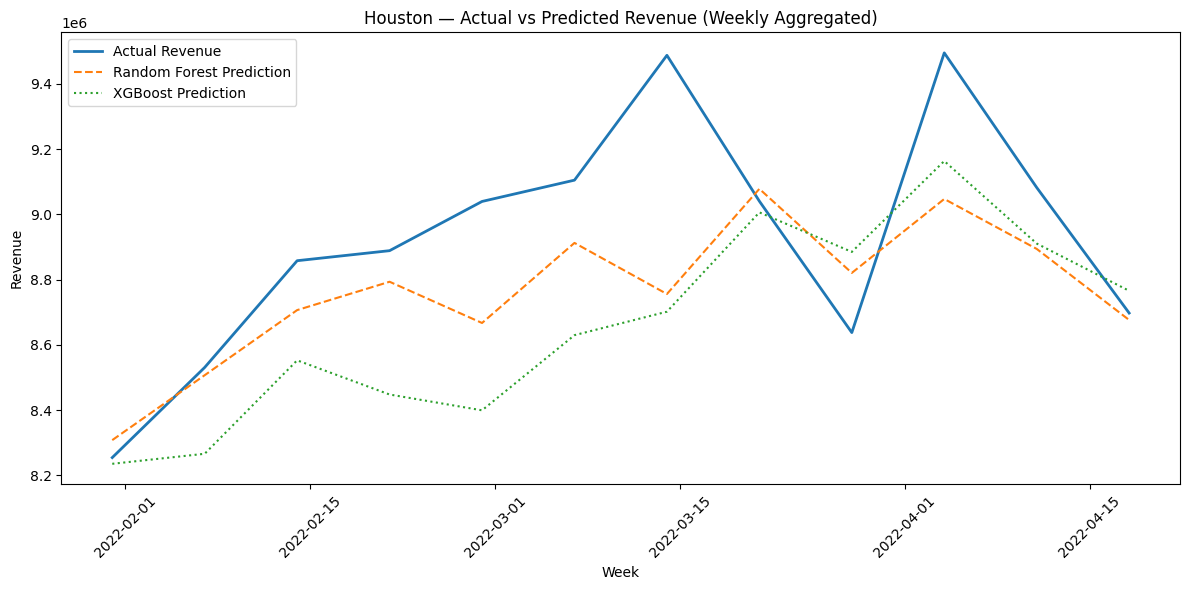

In [78]:
# Start from your fully preprocessed df_houston
df_model = df_houston.copy().reset_index(drop=True)

# Get the last 12 *unique* weeks
last_12_weeks = df_model['week'].drop_duplicates().sort_values().iloc[-12:]

# Filter rows from those weeks
df_test = df_model[df_model['week'].isin(last_12_weeks)].copy()

# The rest of the data is training
df_train = df_model[~df_model.index.isin(df_test.index)].copy()

# Now set X and y
X_train = df_train.drop(columns=['revenue', 'week', 'city'])
y_train = df_train['revenue']
X_test = df_test.drop(columns=['revenue', 'week', 'city'])
y_test = df_test['revenue']

# Train models
rf = RandomForestRegressor(n_estimators=100, random_state=42).fit(X_train, y_train)
xgb = XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42).fit(X_train, y_train)
rf_preds = rf.predict(X_test)
xgb_preds = xgb.predict(X_test)

# Rebuild test DataFrame for plotting
df_test = df_test.reset_index(drop=True)
df_test['actual'] = y_test.reset_index(drop=True)
df_test['rf_pred'] = rf_preds
df_test['xgb_pred'] = xgb_preds

# Aggregate by week
weekly = df_test.groupby('week')[['actual', 'rf_pred', 'xgb_pred']].sum().reset_index()

# Plot
plt.figure(figsize=(12, 6))
plt.plot(weekly['week'], weekly['actual'], label='Actual Revenue', linewidth=2)
plt.plot(weekly['week'], weekly['rf_pred'], label='Random Forest Prediction', linestyle='--')
plt.plot(weekly['week'], weekly['xgb_pred'], label='XGBoost Prediction', linestyle=':')
plt.title("Houston — Actual vs Predicted Revenue (Weekly Aggregated)")
plt.xlabel("Week")
plt.ylabel("Revenue")
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

Modeling Now

In [16]:

# Define parameter search space
param_dist = {
    'n_estimators': randint(100, 500),
    'max_depth': [None] + list(np.arange(5, 30)),
    'min_samples_split': randint(2, 10),
    'min_samples_leaf': randint(1, 10),
    'max_features': ['auto', 'sqrt', 'log2', 0.5, 0.75],
    'bootstrap': [True, False]
}

# Initialize base model
rf_base = RandomForestRegressor(random_state=42)

# RandomizedSearchCV
rf_search = RandomizedSearchCV(
    rf_base,
    param_distributions=param_dist,
    n_iter=30,                 # number of combinations to try
    scoring='neg_root_mean_squared_error',
    cv=3,
    verbose=1,
    random_state=42,
    n_jobs=-1
)

# Fit the search
rf_search.fit(X_train, y_train)

# Get the best model
best_rf = rf_search.best_estimator_

# Evaluate
rf_preds = best_rf.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, rf_preds))
mae = mean_absolute_error(y_test, rf_preds)
r2 = r2_score(y_test, rf_preds)

print("\nBest Random Forest Parameters:")
print(rf_search.best_params_)
print("\nPerformance on Test Set:")
print(f"  RMSE: {rmse:,.2f}")
print(f"  MAE:  {mae:,.2f}")
print(f"  R²:   {r2:.4f}")

Fitting 3 folds for each of 30 candidates, totalling 90 fits


/opt/anaconda3/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:528: FitFailedWarning: 
18 fits failed out of a total of 90.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
18 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py", line 1382, in wrapper
    estimator._validate_params()
  File "/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py", line 436, in _validate_params
    validate_parameter_constraints(
  File "/opt/anaconda3/lib/python3.12/site-pack


Best Random Forest Parameters:
{'bootstrap': True, 'max_depth': np.int64(19), 'max_features': 0.75, 'min_samples_leaf': 2, 'min_samples_split': 8, 'n_estimators': 152}

Performance on Test Set:
  RMSE: 18,167.24
  MAE:  14,024.76
  R²:   0.9980


In [ ]:


# Define the hyperparameter search space
param_dist = {
    'n_estimators': randint(100, 500),
    'learning_rate': uniform(0.01, 0.3),
    'max_depth': randint(3, 10),
    'min_child_weight': randint(1, 10),
    'subsample': uniform(0.6, 0.4),
    'colsample_bytree': uniform(0.6, 0.4),
    'gamma': uniform(0, 0.5)
}

# Initialize base model
xgb_base = XGBRegressor(random_state=42, objective='reg:squarederror')

# Perform randomized search
xgb_search = RandomizedSearchCV(
    xgb_base,
    param_distributions=param_dist,
    n_iter=30,
    scoring='neg_root_mean_squared_error',
    cv=3,
    verbose=1,
    random_state=42,
    n_jobs=-1
)

# Fit the search
xgb_search.fit(X_train, y_train)

# Best model
best_xgb = xgb_search.best_estimator_

# Evaluate
xgb_preds = best_xgb.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, xgb_preds))
mae = mean_absolute_error(y_test, xgb_preds)
r2 = r2_score(y_test, xgb_preds)

print("\nBest XGBoost Parameters:")
print(xgb_search.best_params_)
print("\nPerformance on Test Set:")
print(f"  RMSE: {rmse:,.2f}")
print(f"  MAE:  {mae:,.2f}")
print(f"  R²:   {r2:.4f}")

Fitting 3 folds for each of 30 candidates, totalling 90 fits

Best XGBoost Parameters:
{'colsample_bytree': np.float64(0.9329770563201687), 'gamma': np.float64(0.10616955533913808), 'learning_rate': np.float64(0.06454749016213018), 'max_depth': 7, 'min_child_weight': 1, 'n_estimators': 413, 'subsample': np.float64(0.8099025726528951)}

Performance on Test Set:
  RMSE: 18,438.86
  MAE:  13,073.51
  R²:   0.9980


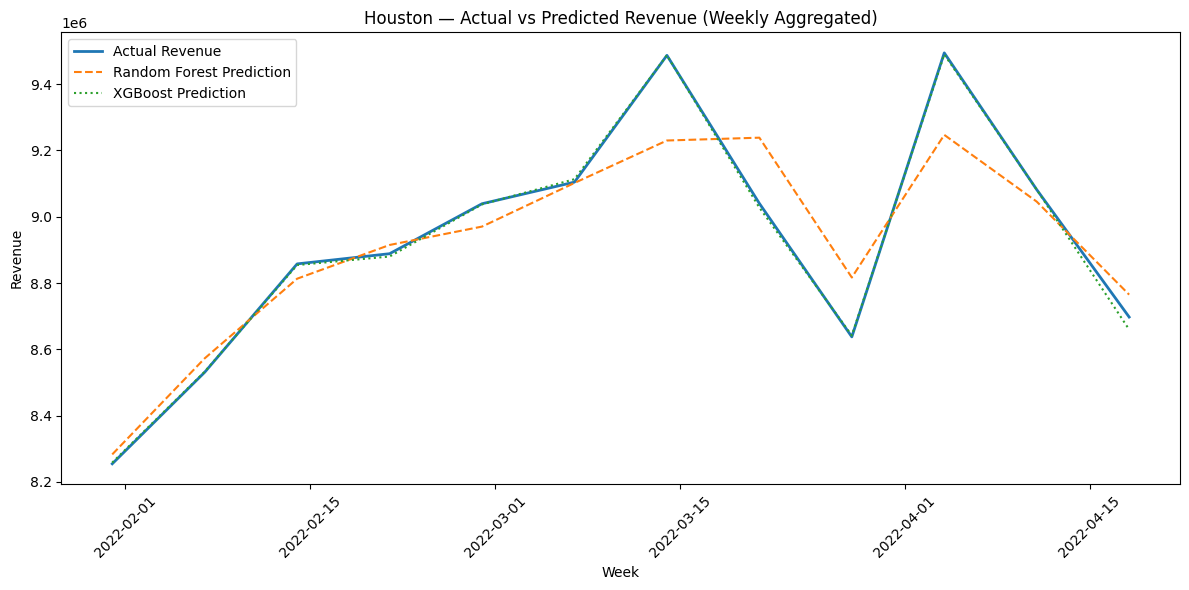

In [81]:
# Get the last 12 *unique* weeks
last_12_weeks = df_houston['week'].drop_duplicates().sort_values().iloc[-12:]

# Find rows that belong to those weeks
df_test = df_houston[df_houston['week'].isin(last_12_weeks)].copy()

# Slice X_test and y_test from that test set
X_test = df_test.drop(columns=['revenue', 'week', 'city'])
y_test = df_test['revenue']
test_weeks = df_test['week'].reset_index(drop=True)

# Re-run predictions using your trained models
rf_preds = best_rf.predict(X_test)
xgb_preds = best_xgb.predict(X_test)

# Build results DataFrame
results_df = pd.DataFrame({
    'week': test_weeks,
    'actual': y_test.reset_index(drop=True),
    'rf_pred': pd.Series(rf_preds),
    'xgb_pred': pd.Series(xgb_preds)
})

# Group by week
weekly = results_df.groupby('week')[['actual', 'rf_pred', 'xgb_pred']].sum().reset_index()

# Plot
plt.figure(figsize=(12, 6))
plt.plot(weekly['week'], weekly['actual'], label='Actual Revenue', linewidth=2)
plt.plot(weekly['week'], weekly['rf_pred'], label='Random Forest Prediction', linestyle='--')
plt.plot(weekly['week'], weekly['xgb_pred'], label='XGBoost Prediction', linestyle=':')
plt.title("Houston — Actual vs Predicted Revenue (Weekly Aggregated)")
plt.xlabel("Week")
plt.ylabel("Revenue")
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()